In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import math
import pandas as pd
from sklearn.utils import shuffle
import h5py
np.random.seed(1)

## Load Dataset

In [2]:
train_images=pd.read_csv('dataset/traindata.csv') #read the csv file
test_images=pd.read_csv('dataset/testdata.csv')
train_images_shuffled=shuffle(train_images)
test_images_shuffled=shuffle(test_images)

In [3]:
def load_dataset():
    #train_dataset

    train_img_path=train_images_shuffled['Xray-img']
    train_images_rgb=[]
    for i in train_img_path:
        img=cv2.imread(i)
        train_images_rgb.append(img)
    train_set_x_orig=np.asarray(train_images_rgb)
    train_set_y_orig =np.array(train_images_shuffled["has-covid19"][:])
    train_set_y_orig =train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    train_classes=np.array(train_images_shuffled["classes"][:])
    
    #test_dataset
    test_img_path=test_images_shuffled['Xray-img']
    test_images_rgb=[]
    for i in test_img_path:
        img=cv2.imread(i)
        test_images_rgb.append(img)
    test_set_x_orig=np.asarray(test_images_rgb)
    test_set_y_orig =np.array(test_images_shuffled["has-covid19"][:])
    test_set_y_orig =test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    test_classes=np.array(test_images_shuffled["classes"][:])
    
    return train_set_x_orig, train_set_y_orig,test_set_x_orig, test_set_y_orig,train_classes,test_classes


In [4]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y,train_classes,test_classes=load_dataset()

In [5]:
#train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_data()

## Reshape train and test data

In [6]:
train_set_x_orig =train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_orig =test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

## Standardize data

In [7]:
train_set_x =train_set_x_orig/255.
test_set_x =test_set_x_orig/255.
train_set_y.shape

(1, 136)

## Helper Fucntions

In [8]:
def sigmoid(z):
    s =1/(1+np.exp(-z))
    return s

In [9]:
def relu(Z):
    relu=np.maximum(0,Z)
    return relu

In [10]:
def getShape(X):
    return X.shape[0]

In [11]:
def sigmoid_derivative(dA,z):
    return dA*z*(1-z)
    

In [12]:
def relu_derivative(dA,z):
    dZ = np.array(dA, copy=True)
    dZ[z <= 0] = 0
    return dZ
    
    
    

## Define Model Size

In [13]:
zero_layer=getShape(train_set_x_orig)
n_layers=[zero_layer,3,2,3,1]

## Initialize Parameters

In [14]:
def initialize_parameters(n_layers,learning_rate):
    np.random.seed(1)
    parameters={}
    L=len(n_layers)
    for i in range(1,L):
        parameters['W'+str(i)]=np.random.randn(n_layers[i],n_layers[i-1])*learning_rate;
        #parameters['W'+str(i)]=np.zeros([n_layers[i],n_layers[i-1]]);
        parameters['b'+str(i)]=np.zeros([n_layers[i],1]);    
    return parameters

## Linear Activation Forward

In [15]:
def linear_activation_forward(X,parameters):
    L=len(parameters)//2
    A=X ##A0
    AL=[]
    caches=[] 
    for i in range(1,L): #for n-1 layers
        W=parameters["W"+str(i)]
        b=parameters["b"+str(i)]
        A_prev=A
        Z=np.dot(W,A_prev)+b
        A=relu(Z)
        #A=sigmoid(Z)
        linear_cache=(W,b,A_prev)
        activation_cache=Z
        cache=(linear_cache,activation_cache)
        caches.append(cache)
        
    #for nth layer
    W=parameters["W"+str(L)]
    b=parameters["b"+str(L)]
    Z=np.dot(W,A)+b
    AL=sigmoid(Z)        #only for last layer
    linear_cache=(W,b,A)
    activation_cache=Z
    cache=(linear_cache,activation_cache)
    caches.append(cache)
    return AL,caches
    

## Cost Function

In [16]:
def compute_cost(AL,Y):
    m=Y.shape[1]
    cost = -(1/m)*((np.dot(Y,(np.log(AL)).T))+(np.dot((1-Y),(np.log(1-AL)).T)))   
    cost = np.squeeze(cost)
    return cost
    

## Linear Activation Backward

In [17]:
def linear_activation_backward(Y,AL,caches):
    L=len(caches) 
    grads={}
    ##last layer
    m=Y.shape[1]
    linear_cache,activation_cache=caches[L-1]
    W,b,A_prev=linear_cache
    dAL=-(np.divide(Y,AL)+np.divide((1-Y),(1-AL))) #dA
    dZ=sigmoid_derivative(activation_cache,dAL) #activation_cache=z
    dA_prev =np.dot(W.T,dZ)
    dW =(1/m)* (np.dot(dZ,A_prev.T))
    db =(1/m)*(np.sum(dZ,axis=1,keepdims=True))
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)]=dA_prev,dW,db
    ##remaining layers
    for l in reversed(range(L-1)):
        linear_cache,activation_cache=caches[l]
        W,b,A_prev=linear_cache
        dZ=relu_derivative(grads["dA" + str(l+1)],activation_cache)
        #dZ=sigmoid_derivative(grads["dA" + str(l+1)],activation_cache)
        dA_prev =np.dot(W.T,dZ)
        dW =(1/m)* (np.dot(dZ,A_prev.T))
        db =(1/m)*(np.sum(dZ,axis=1,keepdims=True))
        grads["dA" + str(l)], grads["dW" + str(l+1)], grads["db" + str(l+1)]= dA_prev,dW,db   
    return grads             
    

## Parameter Updation

In [18]:
def update_parameters(parameters,grads,learning_rate):
    L=len(parameters)//2
    for i in range(1,L):
        parameters['W'+str(i)]=parameters['W'+str(i)]-learning_rate*grads['dW'+str(i)]
        parameters['b'+str(i)]=parameters['b'+str(i)]-learning_rate*grads['db'+str(i)]
    return parameters

## Prediction

In [19]:
def perdict(X,Y,parameters):
    m=Y.shape[1]
    predicted_val=np.zeros((1,m))
    probas, caches = linear_activation_forward(X, parameters)
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            predicted_val[0,i] = 1
        else:
            predicted_val[0,i] = 0
    
    accuracy=(np.sum((predicted_val== Y)/m))*100
        
    return accuracy

## Final DNN Model

In [20]:

def DNN_Model(learning_rate,X,Y,num_of_iterations,n_layers, print_cost=True):
    costs=[]
    parameters=initialize_parameters(n_layers,learning_rate)
    for i in range(num_of_iterations):
        AL,caches=linear_activation_forward(X,parameters)
        cost=compute_cost(AL,Y)
        grads=linear_activation_backward(Y,AL,caches)
        parameters=update_parameters(parameters,grads,learning_rate)
        costs.append(cost)
    if print_cost and i % 100 == 0:
        print ("Cost after iteration %i: %f" %(i, cost))
    if print_cost and i % 100 == 0:
        costs.append(cost)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return parameters

## Calling the model on X-ray Images

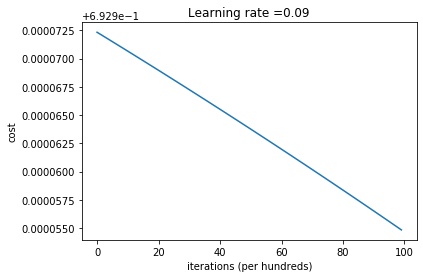

In [21]:
learning_rate=0.09
num_of_iterations=100
##call model
parameters=DNN_Model(learning_rate,train_set_x,train_set_y,num_of_iterations,n_layers,print_cost=True)

## Checking Accuracy for Training Set

In [22]:
accuracy_for_train_set=perdict(train_set_x,train_set_y,parameters)
print("Training Set Accuracy= "+str(accuracy_for_train_set))

Training Set Accuracy= 65.44117647058825


## Checking Accuracy for Test Set

In [23]:
parameters=initialize_parameters(n_layers,learning_rate)
accuracy_for_test_set=perdict(test_set_x,test_set_y,parameters)
print("Test Set Accuracy= "+str(accuracy_for_test_set))

Test Set Accuracy= 64.70588235294117
